# % Clientes que alcanzaron cada paso

La gráfica actual muestra el porcentaje de clientes que alcanzaron cada paso del proceso (es decir, la tasa de conversión en cada etapa). Con esa información puedes deducir el "drop-off" (la caída entre etapas) restando, por ejemplo, el porcentaje de clientes que llegaron a "step_1" del porcentaje que llegaron a "start", y así sucesivamente.

=== Funnel de Conversión a Nivel de Cliente (por paso) ===
variation    Control       Test
start      99.454758  99.050757
step_1     85.544340  90.103554
step_2     79.154650  82.533145
step_3     73.918529  77.312309
confirm    65.248738  68.949557


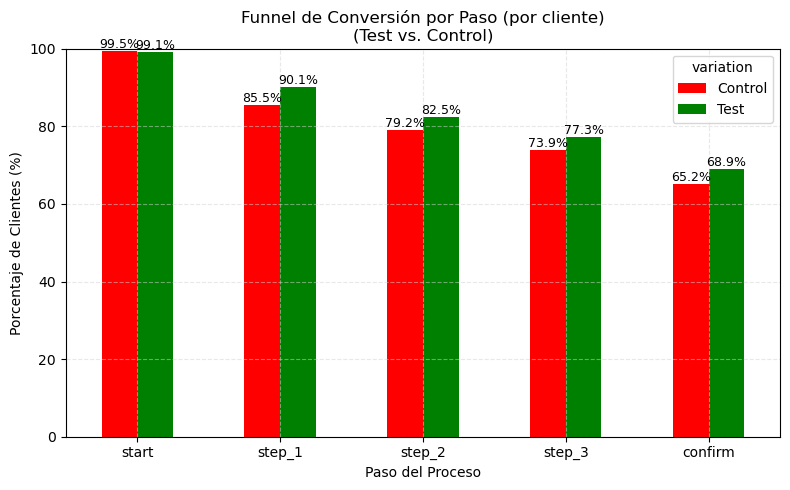

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# Asegurarse de filtrar para los grupos válidos (Test y Control)
df = df[df["variation"].isin(["Test", "Control"])].copy()

# --------------------------------------------------
# PASO 2: Agrupar a nivel de cliente
# --------------------------------------------------
# Para cada cliente (client_id) y su grupo (variation), determinamos si alcanzó cada paso.
# Definimos los pasos del proceso:
steps = ["start", "step_1", "step_2", "step_3", "confirm"]

# Construimos una lista de registros, uno por cliente, con indicadores booleanos para cada paso.
client_records = []
for (variation, client_id), group in df.groupby(["variation", "client_id"]):
    record = {"variation": variation, "client_id": client_id}
    # Para cada paso, verificamos si el cliente tuvo al menos un registro con ese paso
    for step in steps:
        record[step + "_reached"] = group["process_step"].eq(step).any()
    client_records.append(record)

df_clients = pd.DataFrame(client_records)

# --------------------------------------------------
# PASO 3: Calcular el funnel de conversión a nivel de cliente
# --------------------------------------------------
# Para cada grupo (variation) y cada paso, calculamos la tasa (proporción) de clientes que lo alcanzaron.
# Debido a que los indicadores son booleanos, la media equivale a la proporción.
funnel_data = {}
for step in steps:
    col = step + "_reached"
    # Agrupar por variation y calcular la media de ese indicador
    prop = df_clients.groupby("variation")[col].mean() * 100  # convertir a porcentaje
    funnel_data[step] = prop

# Convertir el diccionario a DataFrame, donde las filas son los pasos y las columnas los grupos.
funnel_df = pd.DataFrame(funnel_data).T
# Aseguramos que las filas estén en el orden deseado
funnel_df = funnel_df.reindex(steps)

print("=== Funnel de Conversión a Nivel de Cliente (por paso) ===")
print(funnel_df)

# --------------------------------------------------
# PASO 4: Graficar el funnel de conversión
# --------------------------------------------------
# Definir colores personalizados: Control en rojo y Test en verde.
color_map = {"Control": "red", "Test": "green"}
colors = [color_map.get(col, "gray") for col in funnel_df.columns]

fig, ax = plt.subplots(figsize=(8, 5))
funnel_df.plot(kind="bar", ax=ax, color=colors, legend=True)

ax.set_title("Funnel de Conversión por Paso (por cliente)\n(Test vs. Control)")
ax.set_xlabel("Paso del Proceso")
ax.set_ylabel("Porcentaje de Clientes (%)")
ax.set_ylim(0, 100)
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas con el porcentaje sobre cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1f}%",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/cr_drop-off_funnel.png")
plt.show()


=== Funnel de Conversión a Nivel de Cliente (por paso) ===
variation    Control       Test
start      99.454758  99.050757
step_1     85.544340  90.103554
step_2     79.154650  82.533145
step_3     73.918529  77.312309
confirm    65.248738  68.949557


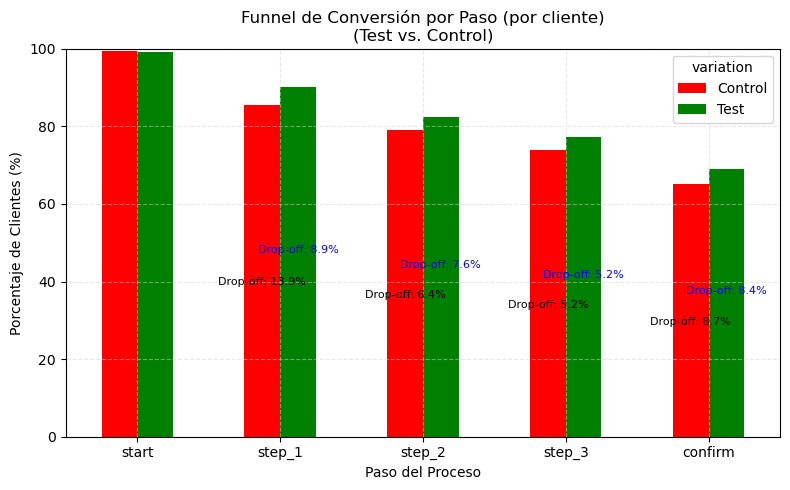

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df = df[df["variation"].isin(["Test", "Control"])].copy()

# --------------------------------------------------
# PASO 2: Agrupar a nivel de cliente y construir el funnel
# --------------------------------------------------
steps = ["start", "step_1", "step_2", "step_3", "confirm"]

client_records = []
for (variation, client_id), group in df.groupby(["variation", "client_id"]):
    record = {"variation": variation, "client_id": client_id}
    for step in steps:
        record[step + "_reached"] = group["process_step"].eq(step).any()
    client_records.append(record)

df_clients = pd.DataFrame(client_records)

# --------------------------------------------------
# PASO 3: Calcular la tasa de conversión (Completion Rate) por paso
# --------------------------------------------------
funnel_data = {}
for step in steps:
    col = step + "_reached"
    # Agrupar por variation y calcular la media (proporción de clientes que alcanzaron el paso)
    prop = df_clients.groupby("variation")[col].mean() * 100  # porcentaje
    funnel_data[step] = prop

funnel_df = pd.DataFrame(funnel_data).T
# Reordenar filas según el orden definido en 'steps'
funnel_df = funnel_df.reindex(steps)

# Seleccionar solo las columnas "Control" y "Test"
funnel_df = funnel_df[["Control", "Test"]]

print("=== Funnel de Conversión a Nivel de Cliente (por paso) ===")
print(funnel_df)

# --------------------------------------------------
# PASO 4: Calcular el drop-off entre pasos
# --------------------------------------------------
# El drop-off se define como la diferencia (en %) entre el paso anterior y el actual para cada grupo.
drop_off_df = funnel_df.shift(1) - funnel_df  # Diferencia con la fila anterior

# --------------------------------------------------
# PASO 5: Graficar el funnel de conversión y anotar el drop-off
# --------------------------------------------------
color_map = {"Control": "red", "Test": "green"}
# Usaremos estos colores para las barras y asignaremos colores distintos para las anotaciones de drop-off:
annot_color = {"Control": "black", "Test": "blue"}

fig, ax = plt.subplots(figsize=(8, 5))
funnel_df.plot(kind="bar", ax=ax, color=[color_map.get(col, "gray") for col in funnel_df.columns], legend=True)

ax.set_title("Funnel de Conversión por Paso (por cliente)\n(Test vs. Control)")
ax.set_xlabel("Paso del Proceso")
ax.set_ylabel("Porcentaje de Clientes (%)")
ax.set_ylim(0, 100)
ax.grid(True, which="major", axis="both", color="lightgray", linestyle="--", alpha=0.5)

# --------------------------------------------------
# PASO 6: Anotar los valores de drop-off en cada barra
# --------------------------------------------------
# Para cada grupo (cada container) y para cada paso (excepto el primero), 
# colocamos la etiqueta de drop-off con un offset vertical distinto según el grupo.
offsets = {"Test": 3, "Control": -3}  # offset en puntos porcentuales
for container, variation in zip(ax.containers, funnel_df.columns):
    for i, rect in enumerate(container):
        # Saltar la primera barra ya que no hay drop-off para el primer paso
        if i == 0:
            continue
        drop_value = drop_off_df.loc[funnel_df.index[i], variation]
        if pd.notna(drop_value) and drop_value > 0:
            # Calcular la posición de la barra
            x = rect.get_x() + rect.get_width() / 2
            # Colocar la etiqueta en el centro vertical de la barra + offset (para separar las dos anotaciones)
            y = rect.get_y() + rect.get_height() / 2 + offsets.get(variation, 0)
            ax.annotate(f"Drop-off: {drop_value:.1f}%",
                        (x, y),
                        ha="center", va="center", fontsize=8, color=annot_color.get(variation, "blue"))

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/cr_drop-off_funnel.png")
plt.show()
